In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Vermont

## Load VEST File

In [2]:
vest_vt_16 = gp.read_file("./raw-from-source/VEST/vt_2016/vt_2016.shp")

## Election Results

### VEST Documentation

Election results from the Vermont Secretary of State (https://vtelectionarchive.sec.state.vt.us/)

Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2016 American Community Survey. (Averill-Canaan, Buels Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

### Load Source Files

In [3]:
all_files = os.listdir("./raw-from-source/Election_Results/Precinct_Level/")
li = []
for file in all_files:
    print(file)
    ref = "./raw-from-source/Election_Results/Precinct_Level/"
    file_ref = ref+file
    file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
    #Only keep the City/Town and Pct columns in one file, as they are duplicated
    #Delete unused columns in others
    if file != 'VT_Elections_Database__2016_Secretary_of_State_General_Election_including_precincts.csv':
        print(file)
        file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
        file_prev = file_prev.drop([0])
    else:
        file_prev = file_prev.drop(['Ward','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
        file_prev = file_prev.drop([0])
    li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
frame = pd.concat(li, axis=1, ignore_index=False)

VT_Elections_Database__2016_Secretary_of_State_General_Election_including_precincts.csv
VT_Elections_Database__2016_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2016_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2016_Treasurer_General_Election_including_precincts.csv
VT_Elections_Database__2016_Treasurer_General_Election_including_precincts.csv
VT_Elections_Database__2016_U_S_Senate_General_Election_including_precincts.csv
VT_Elections_Database__2016_U_S_Senate_General_Election_including_precincts.csv
VT_Elections_Database__2016_Auditor_General_Election_including_precincts.csv
VT_Elections_Database__2016_Auditor_General_Election_including_precincts.csv
VT_Elections_Database__2016_President_General_Election_including_precincts.csv
VT_Elections_Database__2016_President_General_Election_including_precincts.csv
VT_Elections_Database__2016_Lieutenant_Governor_General_Election_including_precincts.csv
VT_Elections_Database__2016_Lieutenan

### Clean up the election results

#### Rename and reorder the columns to match VEST

In [4]:
print(frame.columns)

#Renaming the columns to match VEST
frame.columns = ['NAMELSAD', 'NAMELSAD_1', 'G16SOSOCON', 'G16SOSOHER','G16SOSOWRI', 'G16GOVRSCO', 'G16GOVDMIN', 'G16GOVOLEE',
       'G16GOVOWRI', 'G16TREOPEA', 'G16TREPSCH', 'G16TREONGO', 'G16TREOWRI','G16USSDLEA', 'G16USSRMIL', 'G16USSOERI', 'G16USSITRU',
       'G16USSODIA', 'G16USSOWRI', 'G16AUDDHOF', 'G16AUDRFEL','G16AUDOBRO', 'G16AUDOWRI', 'G16PREDCLI', 'G16PRERTRU',
       'G16PREOSAN', 'G16PRELJOH', 'G16PREGSTE','G16PREIFUE', 'G16PREOLAR','G16PREOWRI', 'G16LTGDZUC', 'G16LTGRBRO', 'G16LTGOWAR',
       'G16LTGOWRI', 'G16HALOWEL', 'G16HALOCLA', 'G16HALOWRI','G16ATGDDON', 'G16ATGRBUC', 'G16ATGOJAC','G16ATGOWRI']

#Reordering the columns to match VEST
frame = frame[['NAMELSAD', 'NAMELSAD_1', 'G16PREDCLI', 'G16PRERTRU','G16PRELJOH', 'G16PREGSTE', 'G16PREIFUE', 'G16PREOLAR', 'G16PREOSAN','G16PREOWRI', 'G16USSDLEA', 'G16USSRMIL', 'G16USSOERI', 'G16USSITRU',
       'G16USSODIA', 'G16USSOWRI', 'G16GOVDMIN', 'G16GOVRSCO', 'G16GOVOLEE','G16GOVOWRI', 'G16LTGDZUC', 'G16LTGRBRO', 'G16LTGOWAR', 'G16LTGOWRI',
       'G16TREOPEA', 'G16TREPSCH', 'G16TREONGO', 'G16TREOWRI', 'G16SOSOCON','G16SOSOHER', 'G16SOSOWRI', 'G16AUDDHOF', 'G16AUDRFEL', 'G16AUDOBRO',
       'G16AUDOWRI', 'G16ATGDDON', 'G16ATGRBUC', 'G16ATGOJAC', 'G16ATGOWRI','G16HALOWEL', 'G16HALOCLA', 'G16HALOWRI']]

Index(['City/Town', 'Pct', 'Jim Condos', 'Mary Alice "Mal" Herbert',
       'Write-Ins', 'Phil Scott', 'Sue Minter', 'Bill "Spaceman" Lee',
       'Write-Ins', 'Beth Pearce', 'Don Schramm', 'Murray Ngoima', 'Write-Ins',
       'Patrick Leahy', 'Scott Milne', 'Cris Ericson', 'Jerry Trudell',
       'Pete Diamondstone', 'Write-Ins', 'Doug Hoffer', 'Dan Feliciano',
       'Marina Brown', 'Write-Ins', 'Hillary Clinton', 'Donald Trump',
       'Bernie Sanders', 'Gary Johnson', 'Jill Stein',
       'Rocky De La Fuente/ Michael', 'Gloria Lariva/ Eugene Puryear',
       'Write-Ins', 'David Zuckerman', 'Randy Brock', 'Boots Wardinski',
       'Write-Ins', 'Peter Welch', 'Erica Clawson', 'Write-Ins',
       'T.J. Donovan', 'Deborah "Deb" Bucknam', 'Rosemarie Jackowski',
       'Write-Ins'],
      dtype='object')


#### Clean the column data types

In [5]:
data_columns = ['G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREIFUE', 'G16PREOLAR', 'G16PREOSAN',
       'G16PREOWRI', 'G16USSDLEA', 'G16USSRMIL', 'G16USSOERI', 'G16USSITRU',
       'G16USSODIA', 'G16USSOWRI', 'G16GOVDMIN', 'G16GOVRSCO', 'G16GOVOLEE',
       'G16GOVOWRI', 'G16LTGDZUC', 'G16LTGRBRO', 'G16LTGOWAR', 'G16LTGOWRI',
       'G16TREOPEA', 'G16TREPSCH', 'G16TREONGO', 'G16TREOWRI', 'G16SOSOCON',
       'G16SOSOHER', 'G16SOSOWRI', 'G16AUDDHOF', 'G16AUDRFEL', 'G16AUDOBRO',
       'G16AUDOWRI', 'G16ATGDDON', 'G16ATGRBUC', 'G16ATGOJAC', 'G16ATGOWRI',
       'G16HALOWEL', 'G16HALOCLA', 'G16HALOWRI']

#Some of the columns include commas to represent numbers in the thousands, this code cleans those
for race in data_columns:
    frame[race]=frame[race].astype(str)
    frame[race]=frame[race].apply(lambda x: x.replace(',',''))
    frame[race]=frame[race].astype(float)
    frame[race]=frame[race].astype(int)

#### Remove rows that count total votes

In [6]:
frame = frame[frame['NAMELSAD']!="TOTALS"]

#### Compare race-wide election totals against VEST

In [7]:
for race in data_columns:
    if (sum(vest_vt_16[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_16[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_16[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All other races are equal")

G16PREOSAN has a difference of 148 votes
	VEST: 18218 votes
	SOURCES: 18070 votes

All other races are equal


#### Look into election result differences

The difference of 148 votes appears to occur because of a typo in the VT precinct-level election results.
Below I uploaded the municipality election results and noted how they count 148 votes (the difference above) for Sanders in Hinesburg, but in the precinct-level election results, where the Hinesburg votes are split between two precincts, there are 0 total votes awarded. 

In [8]:
municipality_file = pd.read_csv("./raw-from-source/Election_Results/Municipal_Level/VT_Elections_Database__2016_President_General_Election.csv")
print(municipality_file[municipality_file["City/Town"]=="Hinesburg"][["City/Town","Bernie Sanders"]])
print(frame[frame["NAMELSAD"]=="Hinesburg"][["NAMELSAD","NAMELSAD_1","G16PREOSAN"]])

    City/Town Bernie Sanders
92  Hinesburg            148
      NAMELSAD      NAMELSAD_1  G16PREOSAN
105  Hinesburg  Chittenden 4-1           0
106  Hinesburg  Chittenden 4-2           0


### Following VEST documentation, allocate votes to the four unorganized towns

#### Documentation

> Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2016 American Community Survey. (Averill-Canaan, Buels Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

#### Add empty precincts to the dataframe (will allocate votes afterwards)

In [9]:
new_df = pd.DataFrame([["Averill","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Buels Gore","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Ferdinand","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Glastenbury","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

#### Load the ACS data

In [10]:
acs_allocating_votes = pd.read_csv("./raw-from-source/ACS/Allocating_Votes/ACSST5Y2016.S0101_2021-05-21T094705/ACSST5Y2016.S0101_data_with_overlays_2021-05-21T092558.csv")        

In [11]:
#Clean up the header
acs_allocating_votes.columns = acs_allocating_votes.iloc[0]
acs_allocating_votes = acs_allocating_votes.drop([0])

#Grab needed columns
acs_allocating_votes = acs_allocating_votes[["Geographic Area Name","Total!!Estimate!!Total population","Total!!Estimate!!SELECTED AGE CATEGORIES!!18 years and over"]]

#Rename columns
acs_allocating_votes.columns=["Place","Pop Estimate","VAP % Estimate"]
print(acs_allocating_votes)

                                          Place Pop Estimate VAP % Estimate
1  Glastenbury town, Bennington County, Vermont            8          100.0
2   Shaftsbury town, Bennington County, Vermont         3533           74.7
3        Buels gore, Chittenden County, Vermont           23           65.2
4   Huntington town, Chittenden County, Vermont         1928           78.9
5           Averill town, Essex County, Vermont           19          100.0
6          Brighton town, Essex County, Vermont          983           81.0
7            Canaan town, Essex County, Vermont         1094           77.7
8         Ferdinand town, Essex County, Vermont           13           61.5


In [12]:
#Turn the estimate column into a percentage from 0 to 1.0
acs_allocating_votes["VAP % Estimate"]=acs_allocating_votes["VAP % Estimate"].apply(lambda x: x.replace('%',''))
acs_allocating_votes["VAP % Estimate"]=acs_allocating_votes["VAP % Estimate"].astype(float)
acs_allocating_votes["VAP % Estimate"]=acs_allocating_votes["VAP % Estimate"]/100

#Change the population estimate from a string to an int
acs_allocating_votes["Pop Estimate"]=acs_allocating_votes["Pop Estimate"].astype(int)

#Create a (rounded) num voters column by multiplying total pop times VAP %
acs_allocating_votes["num_voters"]=round(acs_allocating_votes["Pop Estimate"]*acs_allocating_votes["VAP % Estimate"],0)


In [13]:
print(acs_allocating_votes)

                                          Place  Pop Estimate  VAP % Estimate  \
1  Glastenbury town, Bennington County, Vermont             8           1.000   
2   Shaftsbury town, Bennington County, Vermont          3533           0.747   
3        Buels gore, Chittenden County, Vermont            23           0.652   
4   Huntington town, Chittenden County, Vermont          1928           0.789   
5           Averill town, Essex County, Vermont            19           1.000   
6          Brighton town, Essex County, Vermont           983           0.810   
7            Canaan town, Essex County, Vermont          1094           0.777   
8         Ferdinand town, Essex County, Vermont            13           0.615   

   num_voters  
1         8.0  
2      2639.0  
3        15.0  
4      1521.0  
5        19.0  
6       796.0  
7       850.0  
8         8.0  


In [14]:
#Define a "ratio" column, fill it below with the percentage of voters from the area where votes were counted
acs_allocating_votes["ratio"]=0

#Glastenbury (from Shaftsbury)
acs_allocating_votes.iloc[0,4]=acs_allocating_votes.iloc[0,3]/acs_allocating_votes.iloc[1,3]
#Buels (from Huntington)
acs_allocating_votes.iloc[2,4]=acs_allocating_votes.iloc[2,3]/acs_allocating_votes.iloc[3,3]
#Averill (from Canaan)
acs_allocating_votes.iloc[4,4]=acs_allocating_votes.iloc[4,3]/acs_allocating_votes.iloc[6,3]
#Ferdinand (from Brighton)
acs_allocating_votes.iloc[7,4]=acs_allocating_votes.iloc[7,3]/acs_allocating_votes.iloc[5,3]

print(acs_allocating_votes)

                                          Place  Pop Estimate  VAP % Estimate  \
1  Glastenbury town, Bennington County, Vermont             8           1.000   
2   Shaftsbury town, Bennington County, Vermont          3533           0.747   
3        Buels gore, Chittenden County, Vermont            23           0.652   
4   Huntington town, Chittenden County, Vermont          1928           0.789   
5           Averill town, Essex County, Vermont            19           1.000   
6          Brighton town, Essex County, Vermont           983           0.810   
7            Canaan town, Essex County, Vermont          1094           0.777   
8         Ferdinand town, Essex County, Vermont            13           0.615   

   num_voters     ratio  
1         8.0  0.003031  
2      2639.0  0.000000  
3        15.0  0.009862  
4      1521.0  0.000000  
5        19.0  0.022353  
6       796.0  0.000000  
7       850.0  0.000000  
8         8.0  0.010050  


#### Allocate votes to Averill from Canaan

In [15]:
for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Averill",race] = round(frame.loc[frame["NAMELSAD"]=="Canaan",race].values[0]*.022353,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Canaan",race]= round(frame.loc[frame["NAMELSAD"]=="Canaan",race].values[0]*(1-.022353),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Averill"])
print(frame.loc[frame["NAMELSAD"]=="Canaan"])

    NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
275  Averill                      4           5           0           0   

     G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
275           0           0           0           1  ...           5   

     G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
275           1           0           4           4           1           0   

     G16HALOWEL  G16HALOCLA  G16HALOWRI  
275           7           1           0  

[1 rows x 42 columns]
   NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
47   Canaan        NaN         175         202          12           2   

    G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
47           3           0           0          26  ...         199   

    G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
47          36           0         193         170          23      

#### Allocate votes to Buels Gore from Huntington

In [16]:
frame.loc[frame["NAMELSAD"]=="Huntington"]

for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Buels Gore",race] = round(frame.loc[frame["NAMELSAD"]=="Huntington",race].values[0]*.009862,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Huntington",race]= round(frame.loc[frame["NAMELSAD"]=="Huntington",race].values[0]*(1-.009862),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Buels Gore"])
print(frame.loc[frame["NAMELSAD"]=="Huntington"])

       NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
276  Buels Gore                      8           2           0           0   

     G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
276           0           0           1           0  ...           3   

     G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
276           0           0          10           2           0           0   

     G16HALOWEL  G16HALOCLA  G16HALOWRI  
276          11           1           0  

[1 rows x 42 columns]
       NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
108  Huntington        NaN         788         230          44          35   

     G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
108          10           0         100          21  ...         314   

     G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
108          49           0         954         196

#### Allocate votes to Ferdinand from Brighton

In [17]:
for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Ferdinand",race] = round(frame.loc[frame["NAMELSAD"]=="Brighton",race].values[0]*.010050,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Brighton",race]= round(frame.loc[frame["NAMELSAD"]=="Brighton",race].values[0]*(1-.010050),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Ferdinand"])
print(frame.loc[frame["NAMELSAD"]=="Brighton"])

      NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
277  Ferdinand                      2           3           0           0   

     G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
277           0           0           0           0  ...           2   

     G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
277           1           0           3           2           0           0   

     G16HALOWEL  G16HALOCLA  G16HALOWRI  
277           4           1           0  

[1 rows x 42 columns]
    NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
30  Brighton        NaN         227         273          17           8   

    G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
30           1           0          24           5  ...         228   

    G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
30          74           0         275         219          27

#### Allocate votes to Glastenbury from Shaftsbury

In [18]:
for race in data_columns:
    frame.loc[frame["NAMELSAD"]=="Glastenbury",race] = round(frame.loc[frame["NAMELSAD"]=="Shaftsbury",race].values[0]*.003031,0).astype(int)
    frame.loc[frame["NAMELSAD"]=="Shaftsbury",race]= round(frame.loc[frame["NAMELSAD"]=="Shaftsbury",race].values[0]*(1-.003031),0).astype(int)
print(frame.loc[frame["NAMELSAD"]=="Glastenbury"])
print(frame.loc[frame["NAMELSAD"]=="Shaftsbury"])

        NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
278  Glastenbury                      3           2           0           0   

     G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
278           0           0           0           0  ...           2   

     G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
278           0           0           3           2           1           0   

     G16HALOWEL  G16HALOCLA  G16HALOWRI  
278           5           0           0  

[1 rows x 42 columns]
       NAMELSAD NAMELSAD_1  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  \
191  Shaftsbury        NaN         949         659          53          26   

     G16PREIFUE  G16PREOLAR  G16PREOSAN  G16PREOWRI  ...  G16AUDRFEL  \
191           7           1          93          21  ...         706   

     G16AUDOBRO  G16AUDOWRI  G16ATGDDON  G16ATGRBUC  G16ATGOJAC  G16ATGOWRI  \
191         114           1         850         6

#### Compare race-wide election totals against VEST to make sure totals still match

In [19]:
for race in data_columns:
    if (sum(vest_vt_16[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_16[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_16[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All other races are equal")

G16PREOSAN has a difference of 148 votes
	VEST: 18218 votes
	SOURCES: 18070 votes

All other races are equal


#### Compare county-by-county election totals against VEST (see below)

The election results file does not contain county information, but the shapefile information does, so this will be calculated after joining election results to the shapefile.

#### Compare precinct-by-precinct election results against VEST (see below)

Given the smallness of the file, this will be calculated after joining the election results to the shapefile

## Shapefiles

### VEST Documentation

Shapefile from intersecting the Census county subdivision and State House maps.

### Plot VEST

<AxesSubplot:>

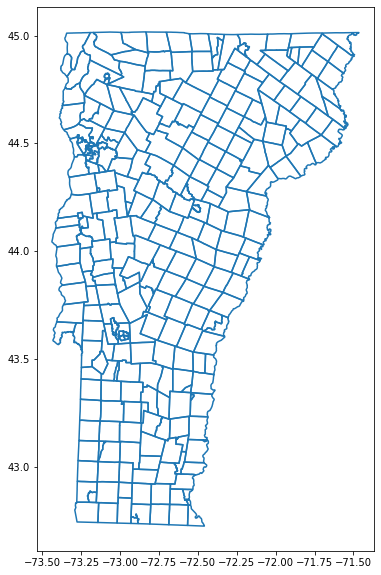

In [20]:
vest_vt_16.boundary.plot(figsize=(10,10))

### Import State District File

In [21]:
state_distr = gp.read_file("./raw-from-source/Shapefiles/VT_Data_-_Vermont_House_Districts_2012/VT_Data_-_Vermont_House_Districts_2012.shp")

#Grab needed columns
state_distr = state_distr[['DISTRICT','NAME','geometry']]

#Modify CRS
state_distr=state_distr.to_crs(vest_vt_16.crs)

In [22]:
county_sub = gp.read_file("./raw-from-source/Shapefiles/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics.shp")

#Grab columns
county_sub = county_sub[['COUNTYFP10','NAME10', 'NAMELSAD10','geometry']]

#Modify CRS
county_sub=county_sub.to_crs(vest_vt_16.crs)

<AxesSubplot:>

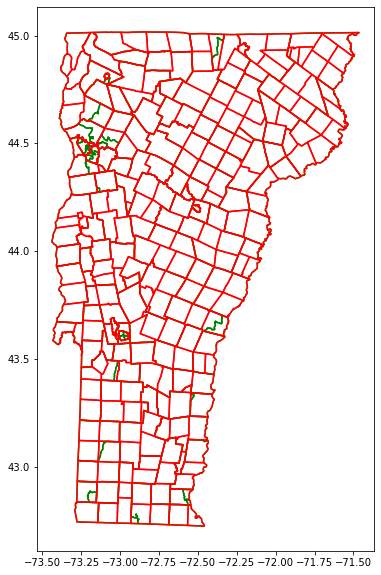

In [23]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = state_distr.boundary.plot(figsize=(10,10),color="green")
county_sub.boundary.plot(figsize=(10,10),ax=ax,color="red")

### Perform the shapefile computation and check the # of rows (looking for 284)

In [24]:
fig = gp.overlay(county_sub, state_distr, how="identity")
fig = fig.to_crs(vest_vt_16.crs)
print(fig.shape)

(284, 6)


<ipython-input-24-ae6a38b8b929>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 696 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  fig = gp.overlay(county_sub, state_distr, how="identity")


### Compare to VEST file

<AxesSubplot:>

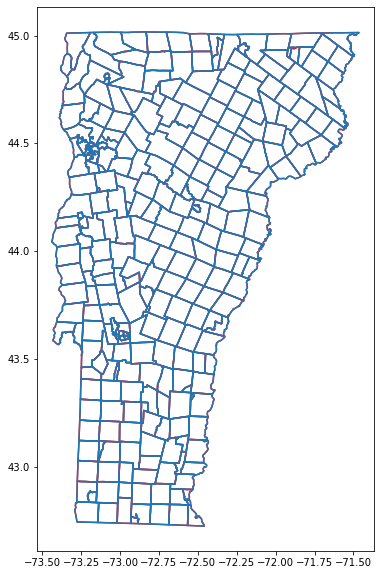

In [25]:
ax_2 = fig.boundary.plot(figsize=(10,10),color="red")
vest_vt_16.boundary.plot(figsize=(10,10),ax=ax_2)

## Join Election Results to Shapefile

### Matching Names

In [26]:
#Check number of rows and try to find a unique ID for each

print(fig.shape)
print(len((fig["NAMELSAD10"]+fig["DISTRICT"]).unique()))
print(frame.shape)
print(frame.columns)
print(len((frame["NAMELSAD"]+frame["NAMELSAD_1"].astype(str)).unique()))

#As you'll notice, there are 5 fewer election result columns

(284, 6)
284
(279, 42)
Index(['NAMELSAD', 'NAMELSAD_1', 'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREIFUE', 'G16PREOLAR', 'G16PREOSAN', 'G16PREOWRI',
       'G16USSDLEA', 'G16USSRMIL', 'G16USSOERI', 'G16USSITRU', 'G16USSODIA',
       'G16USSOWRI', 'G16GOVDMIN', 'G16GOVRSCO', 'G16GOVOLEE', 'G16GOVOWRI',
       'G16LTGDZUC', 'G16LTGRBRO', 'G16LTGOWAR', 'G16LTGOWRI', 'G16TREOPEA',
       'G16TREPSCH', 'G16TREONGO', 'G16TREOWRI', 'G16SOSOCON', 'G16SOSOHER',
       'G16SOSOWRI', 'G16AUDDHOF', 'G16AUDRFEL', 'G16AUDOBRO', 'G16AUDOWRI',
       'G16ATGDDON', 'G16ATGRBUC', 'G16ATGOJAC', 'G16ATGOWRI', 'G16HALOWEL',
       'G16HALOCLA', 'G16HALOWRI'],
      dtype='object')
279


In [27]:
fig["join_col"]=fig["NAMELSAD10"]+"-"+fig["DISTRICT"]
frame["NAMELSAD_1"]=frame["NAMELSAD_1"].fillna("")
frame["join_col"]=frame["NAMELSAD"]+"-"+frame["NAMELSAD_1"].astype(str)

### Change the names to match (look through dictionary to see typical string differences)

In [28]:
name_changes_dict = {'Addison-': 'Addison town-ADD-3', 'Albany-': 'Albany town-ORL-CAL', 'Alburgh-': 'Alburg town-GI-CHI', 'Andover-': 'Andover town-WDR-3-1', 'Arlington-': 'Arlington town-BEN-4', 'Athens-': 'Athens town-WDH-3', 'Averill-': 'Averill town-ESX-CAL-ORL', 'Bakersfield-': 'Bakersfield town-FRA-6', 'Baltimore-': 'Baltimore town-WDR-3-1', 'Barnard-': 'Barnard town-WDR-4-1', 'Barnet-': 'Barnet town-CAL-1', 'Barre City-': 'Barre city-WAS-3', 'Barre Town-': 'Barre town-WAS-2', 'Barton-': 'Barton town-ORL-CAL', 'Belvidere-': 'Belvidere town-LAM-2', 'Bennington-Bennington 2-1': 'Bennington town-BEN-2-1', 'Bennington-Bennington 2-2': 'Bennington town-BEN-2-2', 'Benson-': 'Benson town-ADD-RUT', 'Berkshire-': 'Berkshire town-FRA-5', 'Berlin-': 'Berlin town-WAS-1', 'Bethel-': 'Bethel town-WDR-RUT', 'Bloomfield-': 'Bloomfield town-ESX-CAL-ORL', 'Bolton-': 'Bolton town-WAS-CHI', 'Bradford-': 'Bradford town-ORA-2', 'Braintree-': 'Braintree town-ORA-WAS-ADD', 'Brandon-': 'Brandon town-RUT-6', 'Brattleboro-Windham 2-1': 'Brattleboro town-WDH-2-1', 'Brattleboro-Windham 2-2': 'Brattleboro town-WDH-2-2', 'Brattleboro-Windham 2-3': 'Brattleboro town-WDH-2-3', 'Bridgewater-': 'Bridgewater town-RUT-WDR-1', 'Bridport-': 'Bridport town-ADD-5', 'Brighton-': 'Brighton town-ESX-CAL-ORL', 'Bristol-': 'Bristol town-ADD-4', 'Brookfield-': 'Brookfield town-ORA-WAS-ADD', 'Brookline-': 'Brookline town-WDH-3', 'Brownington-': 'Brownington town-ORL-1', 'Brunswick-': 'Brunswick town-ESX-CAL', 'Buels Gore-': 'Buels gore-WAS-CHI', 'Burke-': 'Burke town-CAL-4', 'Burlington-Chittenden 6-1': 'Burlington city-CHI-6-1', 'Burlington-Chittenden 6-2': 'Burlington city-CHI-6-2', 'Burlington-Chittenden 6-3': 'Burlington city-CHI-6-3', 'Burlington-Chittenden 6-4': 'Burlington city-CHI-6-4', 'Burlington-Chittenden 6-5': 'Burlington city-CHI-6-5', 'Burlington-Chittenden 6-6': 'Burlington city-CHI-6-6', 'Burlington-Chittenden 6-7': 'Burlington city-CHI-6-7', 'Cabot-': 'Cabot town-CAL-WAS', 'Calais-': 'Calais town-WAS-6', 'Cambridge-': 'Cambridge town-LAM-3', 'Canaan-': 'Canaan town-ESX-CAL-ORL', 'Castleton-': 'Castleton town-RUT-3', 'Cavendish-': 'Cavendish town-WDR-2', 'Charleston-': 'Charleston town-ORL-1', 'Charlotte-': 'Charlotte town-CHI-4-1', 'Chelsea-': 'Chelsea town-ORA-1', 'Chester-': 'Chester town-WDR-3-1', 'Chittenden-': 'Chittenden town-RUT-WDR-1', 'Clarendon-': 'Clarendon town-RUT-2', 'Colchester-Chittenden 9-1': 'Colchester town-CHI-9-1', 'Colchester-Chittenden 9-2': 'Colchester town-CHI-9-2', 'Concord-': 'Concord town-ESX-CAL', 'Corinth-': 'Corinth town-ORA-1', 'Cornwall-': 'Cornwall town-ADD-2', 'Coventry-': 'Coventry town-ORL-2', 'Craftsbury-': 'Craftsbury town-ORL-CAL', 'Danby-': 'Danby town-BEN-RUT', 'Danville-': 'Danville town-CAL-WAS', 'Derby-': 'Derby town-ORL-1', 'Dorset-': 'Dorset town-BEN-RUT', 'Dover-': 'Dover town-WDH-BEN', 'Dummerston-': 'Dummerston town-WDH-4', 'Duxbury-': 'Duxbury town-WAS-7', 'E. Haven-': 'East Haven town-ESX-CAL-ORL', 'E. Montpelier-': 'East Montpelier town-WAS-5', 'Eden-': 'Eden town-ORL-LAM', 'Elmore-': 'Elmore town-LAM-WAS', 'Enosburgh-': 'Enosburg town-FRA-7', 'Essex-Chittenden 8-1': 'Essex town-CHI-8-1', 'Essex-Chittenden 8-2': 'Essex town-CHI-8-2', 'Essex-Chittenden 8-3': 'Essex town-CHI-8-3', 'Fair Haven-': 'Fair Haven town-RUT-3', 'Fairfax-': 'Fairfax town-FRA-2', 'Fairfield-': 'Fairfield town-FRA-6', 'Fairlee-': 'Fairlee town-ORA-2', 'Fayston-': 'Fayston town-WAS-7', 'Ferdinand-': 'Ferdinand town-ESX-CAL-ORL', 'Ferrisburgh-': 'Ferrisburgh town-ADD-3', 'Fletcher-': 'Fletcher town-FRA-6', 'Franklin-': 'Franklin town-FRA-5', 'Georgia-': 'Georgia town-FRA-1', 'Glastenbury-': 'Glastenbury town-BEN-3', 'Glover-': 'Glover town-ORL-CAL', 'Goshen-': 'Goshen town-ADD-2', 'Grafton-': 'Grafton town-WDH-3', 'Granby-': 'Granby town-ESX-CAL', 'Grand Isle-': 'Grand Isle town-GI-CHI', 'Granville-': 'Granville town-ORA-WAS-ADD', 'Greensboro-': 'Greensboro town-ORL-CAL', 'Groton-': 'Groton town-ORA-CAL', 'Guildhall-': 'Guildhall town-ESX-CAL', 'Guilford-': 'Guilford town-WDH-1', 'Halifax-': 'Halifax town-WDH-6', 'Hancock-': 'Hancock town-ADD-2', 'Hardwick-': 'Hardwick town-CAL-2', 'Hartford-Windsor 4-1': 'Hartford town-WDR-4-1', 'Hartford-Windsor 4-2': 'Hartford town-WDR-4-2', 'Hartland-': 'Hartland town-WDR-1', 'Highgate-': 'Highgate town-FRA-5', 'Hinesburg-Chittenden 4-1': 'Hinesburg town-CHI-4-1', 'Hinesburg-Chittenden 4-2': 'Hinesburg town-CHI-4-2', 'Holland-': 'Holland town-ORL-1', 'Hubbardton-': 'Hubbardton town-RUT-3', 'Huntington-': 'Huntington town-WAS-CHI', 'Hyde Park-': 'Hyde Park town-LAM-2', 'Ira-': 'Ira town-RUT-1', 'Irasburg-': 'Irasburg town-ORL-2', 'Isle La Motte-': 'Isle La Motte town-GI-CHI', 'Jamaica-': 'Jamaica town-WDH-BEN-WDR', 'Jay-': 'Jay town-ORL-LAM', 'Jericho-': 'Jericho town-CHI-3', 'Johnson-': 'Johnson town-LAM-2', 'Killington-': 'Killington town-RUT-WDR-1', 'Kirby-': 'Kirby town-ESX-CAL', 'Landgrove-': 'Landgrove town-BEN-RUT', 'Leicester-': 'Leicester town-ADD-2', 'Lemington-': 'Lemington town-ESX-CAL-ORL', 'Lincoln-': 'Lincoln town-ADD-4', 'Londonderry-': 'Londonderry town-WDH-BEN-WDR', 'Lowell-': 'Lowell town-ORL-LAM', 'Ludlow-': 'Ludlow town-RUT-WDR-2', 'Lunenburg-': 'Lunenburg town-ESX-CAL', 'Lyndon-': 'Lyndon town-CAL-4', 'Maidstone-': 'Maidstone town-ESX-CAL', 'Manchester-': 'Manchester town-BEN-4', 'Marlboro-': 'Marlboro town-WDH-5', 'Marshfield-': 'Marshfield town-WAS-6', 'Mendon-': 'Mendon town-RUT-WDR-1', 'Middlebury-': 'Middlebury town-ADD-1', 'Middlesex-': 'Middlesex town-WAS-5', 'Middletown Springs-': 'Middletown Springs town-RUT-BEN', 'Milton-Chittenden 10': 'Milton town-CHI-10', 'Milton-Grand Isle-Chittenden': 'Milton town-GI-CHI', 'Monkton-': 'Monkton town-ADD-4', 'Montgomery-': 'Montgomery town-FRA-7', 'Montpelier-': 'Montpelier city-WAS-4', 'Moretown-': 'Moretown town-WAS-7', 'Morgan-': 'Morgan town-ORL-1', 'Morristown-': 'Morristown town-LAM-WAS', 'Mount Holly-': 'Mount Holly town-RUT-WDR-2', 'Mount Tabor-': 'Mount Tabor town-BEN-RUT', 'N. Hero-': 'North Hero town-GI-CHI', 'New Haven-': 'New Haven town-ADD-5', 'Newark-': 'Newark town-ESX-CAL-ORL', 'Newbury-': 'Newbury town-ORA-CAL', 'Newfane-': 'Newfane town-WDH-5', 'Newport City-': 'Newport city-ORL-2', 'Newport Town-': 'Newport town-ORL-2', 'Northfield-': 'Northfield town-WAS-1', 'Norton-': 'Norton town-ESX-CAL-ORL', 'Norwich-': 'Norwich town-WDR-ORA-2', 'Orange-': 'Orange town-ORA-1', 'Orwell-': 'Orwell town-ADD-RUT', 'Panton-': 'Panton town-ADD-3', 'Pawlet-': 'Pawlet town-RUT-BEN', 'Peacham-': 'Peacham town-CAL-WAS', 'Peru-': 'Peru town-BEN-RUT', 'Pittsfield-': 'Pittsfield town-WDR-RUT', 'Pittsford-': 'Pittsford town-RUT-6', 'Plainfield-': 'Plainfield town-WAS-6', 'Plymouth-': 'Plymouth town-WDR-5', 'Pomfret-': 'Pomfret town-WDR-4-1', 'Poultney-': 'Poultney town-RUT-1', 'Pownal-': 'Pownal town-BEN-1', 'Proctor-': 'Proctor town-RUT-2', 'Putney-': 'Putney town-WDH-4', 'Randolph-': 'Randolph town-ORA-WAS-ADD', 'Reading-': 'Reading town-WDR-5', 'Readsboro-': 'Readsboro town-WDH-BEN', 'Richford-': 'Richford town-FRA-5', 'Richmond-': 'Richmond town-CHI-1', 'Ripton-': 'Ripton town-ADD-2', 'Rochester-': 'Rochester town-WDR-RUT', 'Rockingham-': 'Rockingham town-WDH-3', 'Roxbury-': 'Roxbury town-ORA-WAS-ADD', 'Royalton-': 'Royalton town-WDR-ORA-1', 'Rupert-': 'Rupert town-RUT-BEN', 'Rutland City-Rutland 5-1': 'Rutland city-RUT-5-1', 'Rutland City-Rutland 5-2': 'Rutland city-RUT-5-2', 'Rutland City-Rutland 5-3': 'Rutland city-RUT-5-3', 'Rutland City-Rutland 5-4': 'Rutland city-RUT-5-4', 'Rutland Town-': 'Rutland town-RUT-4', 'Ryegate-': 'Ryegate town-CAL-1', 'S. Burlington-Chittenden 7-1': 'South Burlington city-CHI-7-1', 'S. Burlington-Chittenden 7-2': 'South Burlington city-CHI-7-2', 'S. Burlington-Chittenden 7-3': 'South Burlington city-CHI-7-3', 'S. Burlington-Chittenden 7-4': 'South Burlington city-CHI-7-4', 'S. Hero-': 'South Hero town-GI-CHI', 'Salisbury-': 'Salisbury town-ADD-2', 'Sandgate-': 'Sandgate town-BEN-4', 'Searsburg-': 'Searsburg town-WDH-BEN', 'Shaftsbury-': 'Shaftsbury town-BEN-3', 'Sharon-': 'Sharon town-WDR-ORA-2', 'Sheffield-': 'Sheffield town-ORL-CAL', 'Shelburne-Chittenden 5-1': 'Shelburne town-CHI-5-1', 'Shelburne-Chittenden 5-2': 'Shelburne town-CHI-5-2', 'Sheldon-': 'Sheldon town-FRA-4', 'Shoreham-': 'Shoreham town-ADD-RUT', 'Shrewsbury-': 'Shrewsbury town-RUT-WDR-2', 'Springfield-Windsor 3-1': 'Springfield town-WDR-3-1', 'Springfield-Windsor 3-2': 'Springfield town-WDR-3-2', 'St. Albans City-': 'St. Albans city-FRA-3-1', 'St. Albans Town-Franklin 3-1': 'St. Albans town-FRA-3-1', 'St. Albans Town-Franklin 3-2': 'St. Albans town-FRA-3-2', 'St. George-': 'St. George town-CHI-5-2', 'St. Johnsbury-': 'St. Johnsbury town-CAL-3', 'Stamford-': 'Stamford town-WDH-BEN', 'Stannard-': 'Stannard town-CAL-2', 'Starksboro-': 'Starksboro town-ADD-4', 'Stockbridge-': 'Stockbridge town-WDR-RUT', 'Stowe-': 'Stowe town-LAM-1', 'Strafford-': 'Strafford town-WDR-ORA-2', 'Stratton-': 'Stratton town-WDH-BEN-WDR', 'Sudbury-': 'Sudbury town-RUT-6', 'Sunderland-Bennington 3': 'Sunderland town-BEN-3', 'Sunderland-Bennington 4': 'Sunderland town-BEN-4', 'Sutton-': 'Sutton town-CAL-4', 'Swanton-': 'Swanton town-FRA-4', 'Thetford-': 'Thetford town-WDR-ORA-2', 'Tinmouth-Rutland 2': 'Tinmouth town-RUT-2', 'Tinmouth-Rutland-Bennington': 'Tinmouth town-RUT-BEN', 'Topsham-': 'Topsham town-ORA-CAL', 'Townshend-': 'Townshend town-WDH-5', 'Troy-Orleans 2': 'Troy town-ORL-2', 'Troy-Orleans-Lamoille': 'Troy town-ORL-LAM', 'Tunbridge-': 'Tunbridge town-WDR-ORA-1', 'Underhill-': 'Underhill town-CHI-3',
                     'Vergennes-': 'Vergennes city-ADD-3', 'Vernon-': 'Vernon town-WDH-1', 'Vershire-': 'Vershire town-ORA-1', 'Victory-': 'Victory town-ESX-CAL', 'W. Fairlee-': 'West Fairlee town-ORA-2', 'W. Haven-': 'West Haven town-RUT-3', 'W. Rutland-': 'West Rutland town-RUT-2', 'W. Windsor-': 'West Windsor town-WDR-1', 'Waitsfield-': 'Waitsfield town-WAS-7', 'Walden-': 'Walden town-CAL-2', 'Wallingford-': 'Wallingford town-RUT-2', 'Waltham-': 'Waltham town-ADD-3', 'Wardsboro-': 'Wardsboro town-WDH-BEN', 'Warren-': 'Warren town-WAS-7', 'Washington-': 'Washington town-ORA-1', 'Waterbury-': 'Waterbury town-WAS-CHI', 'Waterford-': 'Waterford town-CAL-1', 'Waterville-': 'Waterville town-LAM-3', 'Weathersfield-': 'Weathersfield town-WDR-2', 'Wells-': 'Wells town-RUT-BEN', 'Westfield-': 'Westfield town-ORL-LAM', 'Westford-': 'Westford town-CHI-8-3', 'Westminster-Windham 3': 'Westminster town-WDH-3', 'Westminster-Windham 4': 'Westminster town-WDH-4', 'Westmore-': 'Westmore town-ESX-CAL-ORL', 'Weston-': 'Weston town-WDH-BEN-WDR', 'Weybridge-': 'Weybridge town-ADD-5', 'Wheelock-': 'Wheelock town-ORL-CAL', 'Whiting-': 'Whiting town-ADD-RUT', 'Whitingham-Windham 6': 'Whitingham town-WDH-6', 'Whitingham-Windham-Bennington': 'Whitingham town-WDH-BEN', 'Williamstown-': 'Williamstown town-ORA-1', 'Williston-': 'Williston town-CHI-2', 'Wilmington-': 'Wilmington town-WDH-6', 'Windham-': 'Windham town-WDH-3', 'Windsor-': 'Windsor town-WDR-1', 'Winhall-': 'Winhall town-WDH-BEN-WDR', 'Winooski-': 'Winooski city-CHI-6-7', 'Wolcott-': 'Wolcott town-LAM-2', 'Woodbury-': 'Woodbury town-LAM-WAS', 'Woodford-': 'Woodford town-BEN-1', 'Woodstock-': 'Woodstock town-WDR-5', 'Worcester-': 'Worcester town-LAM-WAS'}




In [29]:
frame["join_col"] = frame["join_col"].map(name_changes_dict).fillna(0)

### Attempt to join

In [30]:
source_join = pd.merge(frame,fig,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          279
right_only      5
left_only       0
Name: _merge, dtype: int64


### Look into unjoined precincts

In [31]:
print(source_join[source_join["_merge"]=="right_only"]["join_col"])

279      Avery's gore-ESX-CAL-ORL
280        Lewis town-ESX-CAL-ORL
281    Warner's grant-ESX-CAL-ORL
282     Warren's gore-ESX-CAL-ORL
283         Somerset town-WDH-BEN
Name: join_col, dtype: object


### Deal with no-vote precincts

Since VEST does not mention these in their documentation, nor a source for how they know when to allocate votes to precincts, we want to check whether it's reasonable to add these as no-vote precincts, without any vote allocation.

This is what VEST did, so this step is also verifying some of their work.

In [32]:
acs_empty_precincts = pd.read_csv("./raw-from-source/ACS/Empty_Precincts/ACSST5Y2016.S0101_2021-05-21T094727/ACSST5Y2016.S0101_data_with_overlays_2021-05-21T094726.csv")

In [33]:
acs_empty_precincts.columns = acs_empty_precincts.iloc[0]
acs_empty_precincts = acs_empty_precincts.drop([0])
acs_empty_precincts = acs_empty_precincts[["Geographic Area Name","Total!!Estimate!!Total population","Total!!Margin of Error!!Total population"]]
acs_empty_precincts = acs_empty_precincts[acs_empty_precincts["Geographic Area Name"]!="Buels gore, Chittenden County, Vermont"]

In [34]:
#As you can see 4 of these 5 have a 0 population estimate
#Although Somerset has an estimate of 9, there is a large MOE
#However, since some of the precincts where votes were allocated had tiny pops, we'll look a bit more into it.
acs_empty_precincts

,Geographic Area Name,Total!!Estimate!!Total population,Total!!Margin of Error!!Total population
2,"Avery's gore, Essex County, Vermont",0,9
3,"Lewis town, Essex County, Vermont",0,9
4,"Warner's grant, Essex County, Vermont",0,9
5,"Warren's gore, Essex County, Vermont",0,9
6,"Somerset town, Windham County, Vermont",9,12


### Look into Somerset

#### News Article

This 2016 news article (https://www.reformer.com/local-news/the-lone-voter-of-somerset/article_b06ff1fb-b678-55c4-98cc-0afb3e2480ca.html) mentions Somerset only having 1 registered voter.

> "...one of two full-time residents in the unorganized town and Somerset's only registered voter."

#### 2019 ACS

As you can see below, the area has a 0 population estimate in 2019, which supports not trying to allocate the area any votes

In [35]:
acs_somerset_2019 = pd.read_csv("./raw-from-source/ACS/Somerset_2019/ACSST5Y2019.S0101_2021-05-21T094744/ACSST5Y2019.S0101_data_with_overlays_2021-05-21T094742.csv")

acs_somerset_2019.columns = acs_somerset_2019.iloc[0]
acs_somerset_2019 = acs_somerset_2019.drop([0])
acs_somerset_2019 = acs_somerset_2019[acs_somerset_2019["Geographic Area Name"]!="Buels gore, Chittenden County, Vermont"]
acs_somerset_2019 = acs_somerset_2019[["Geographic Area Name",'Estimate!!Total!!Total population','Margin of Error!!Total!!Total population']]
acs_somerset_2019.columns = ["Area","Pop EST.","Pop MOE"]
print(acs_somerset_2019)

                                     Area Pop EST. Pop MOE
2  Somerset town, Windham County, Vermont        0       9


### Add the zero-vote precincts

In [36]:
new_df = pd.DataFrame([["Avery's gore","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Avery's gore-ESX-CAL-ORL"],
                       ["Lewis town","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Lewis town-ESX-CAL-ORL"],
                       ["Warner's grant","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warner's grant-ESX-CAL-ORL"],
                       ["Warren's gore","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warren's gore-ESX-CAL-ORL"],
                       ["Somerset town","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Somerset town-WDH-BEN"]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

### Attempt to join again

In [37]:
source_join = pd.merge(frame,fig,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          284
left_only       0
right_only      0
Name: _merge, dtype: int64


## Join Source File to VEST File

### Clean columns

In [38]:
source_join = source_join[['COUNTYFP10',"NAMELSAD10","NAME",'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREIFUE', 'G16PREOLAR', 'G16PREOSAN', 'G16PREOWRI',
       'G16USSDLEA', 'G16USSRMIL', 'G16USSOERI', 'G16USSITRU', 'G16USSODIA',
       'G16USSOWRI', 'G16GOVDMIN', 'G16GOVRSCO', 'G16GOVOLEE', 'G16GOVOWRI',
       'G16LTGDZUC', 'G16LTGRBRO', 'G16LTGOWAR', 'G16LTGOWRI', 'G16TREOPEA',
       'G16TREPSCH', 'G16TREONGO', 'G16TREOWRI', 'G16SOSOCON', 'G16SOSOHER',
       'G16SOSOWRI', 'G16AUDDHOF', 'G16AUDRFEL', 'G16AUDOBRO', 'G16AUDOWRI',
       'G16ATGDDON', 'G16ATGRBUC', 'G16ATGOJAC', 'G16ATGOWRI', 'G16HALOWEL',
       'G16HALOCLA', 'G16HALOWRI','geometry']]

### Define a unique ID for the final join

In [39]:
source_join["final_join_col"]=source_join["NAMELSAD10"]+"-"+source_join["NAME"]+" State House District"

### Create a unique ID for VEST

In [40]:
print(vest_vt_16.shape)
print(len((vest_vt_16["NAMELSAD"]+"-"+vest_vt_16["NAMELSAD_1"]).unique()))
vest_vt_16["final_join_col"]=vest_vt_16["NAMELSAD"]+"-"+vest_vt_16["NAMELSAD_1"]

(284, 44)
284


In [41]:
final_merge = pd.merge(vest_vt_16,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          273
left_only      11
right_only     11
Name: final_merge, dtype: int64

### Modify Columns

In [42]:
source_to_vest_changes_dict = {'Alburg town-Grand Isle-Chittenden State House District': 'Alburgh town-Grand-Isle-Chittenden State House District', 'Benson town-Addison Rutland State House District': 'Benson town-Addison-Rutland State House District', 'Enosburg town-Franklin-7 State House District': 'Enosburgh town-Franklin-7 State House District', 'Grand Isle town-Grand Isle-Chittenden State House District': 'Grand Isle town-Grand-Isle-Chittenden State House District', 'Isle La Motte town-Grand Isle-Chittenden State House District': 'Isle La Motte town-Grand-Isle-Chittenden State House District', 'Milton town-Grand Isle-Chittenden State House District': 'Milton town-Grand-Isle-Chittenden State House District', 'North Hero town-Grand Isle-Chittenden State House District': 'North Hero town-Grand-Isle-Chittenden State House District', 'Orwell town-Addison Rutland State House District': 'Orwell town-Addison-Rutland State House District', 'Shoreham town-Addison Rutland State House District': 'Shoreham town-Addison-Rutland State House District', 'South Hero town-Grand Isle-Chittenden State House District': 'South Hero town-Grand-Isle-Chittenden State House District', 'Whiting town-Addison Rutland State House District': 'Whiting town-Addison-Rutland State House District'}

source_join["final_join_col"] = source_join["final_join_col"].map(source_to_vest_changes_dict).fillna(source_join["final_join_col"])


In [43]:
final_merge = pd.merge(vest_vt_16,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          284
left_only       0
right_only      0
Name: final_merge, dtype: int64

## Validate Election Results

### County-by-county

The only difference is the one explained above with the 148 votes.

In [44]:
diff_counties=[]
for i in data_columns:
    diff = source_join.groupby(["COUNTYFP10"]).sum()[i]-vest_vt_16.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("All other races in all counties are equal")

007   -148
All other races in all counties are equal


### Precinct-by-precinct

In [45]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [46]:
validater_row(final_merge,data_columns)

G16AUDRFEL ................Canaan town-Essex-Caledonia-Orleans State House District (V) ..200  (S)..199 (D):   -1
G16ATGDDON ...................Buels gore-Washington-Chittenden State House District (V) ....9  (S)...10 (D):    1
G16AUDRFEL ...............Averill town-Essex-Caledonia-Orleans State House District (V) ....4  (S)....5 (D):    1
G16PREOSAN ......................Hinesburg town-Chittenden-4-2 State House District (V) ..148  (S)....0 (D): -148
G16ATGDDON ..............Huntington town-Washington-Chittenden State House District (V) ..955  (S)..954 (D):   -1

There are  284  total rows
5  of these rows have election result differences
279  of these rows are the same

The max difference between any one shared column in a row is:  148
The average difference is:  30.4
There are  1 precinct results with a difference greater than 10
['Averill town-Essex-Caledonia-Orleans State House District', 'Buels gore-Washington-Chittenden State House District', 'Canaan town-Essex-Caledonia-Orleans

The only major difference is the one explained above with the 148 votes, the other 4 differences are due to differences in how votes were rounded.

## Validate Geometry

In [48]:
print(final_merge.columns)

Index(['COUNTYFP', 'NAMELSAD', 'NAMELSAD_1', 'G16PREDCLI_x', 'G16PRERTRU_x',
       'G16PRELJOH_x', 'G16PREGSTE_x', 'G16PREIFUE_x', 'G16PREOLAR_x',
       'G16PREOSAN_x', 'G16PREOWRI_x', 'G16USSDLEA_x', 'G16USSRMIL_x',
       'G16USSOERI_x', 'G16USSITRU_x', 'G16USSODIA_x', 'G16USSOWRI_x',
       'G16GOVDMIN_x', 'G16GOVRSCO_x', 'G16GOVOLEE_x', 'G16GOVOWRI_x',
       'G16LTGDZUC_x', 'G16LTGRBRO_x', 'G16LTGOWAR_x', 'G16LTGOWRI_x',
       'G16TREOPEA_x', 'G16TREPSCH_x', 'G16TREONGO_x', 'G16TREOWRI_x',
       'G16SOSOCON_x', 'G16SOSOHER_x', 'G16SOSOWRI_x', 'G16AUDDHOF_x',
       'G16AUDRFEL_x', 'G16AUDOBRO_x', 'G16AUDOWRI_x', 'G16ATGDDON_x',
       'G16ATGRBUC_x', 'G16ATGOJAC_x', 'G16ATGOWRI_x', 'G16HALOWEL_x',
       'G16HALOCLA_x', 'G16HALOWRI_x', 'geometry_x', 'final_join_col',
       'COUNTYFP10', 'NAMELSAD10', 'NAME', 'G16PREDCLI_y', 'G16PRERTRU_y',
       'G16PRELJOH_y', 'G16PREGSTE_y', 'G16PREIFUE_y', 'G16PREOLAR_y',
       'G16PREOSAN_y', 'G16PREOWRI_y', 'G16USSDLEA_y', 'G16USSRMIL_

In [49]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_vt_16.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_vt_16.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    284
dtype: int64


1) For Maidstone town difference in area is 0.12015599919608085
2) For Guildhall town difference in area is 0.13107733828079945
3) For Norton town difference in area is 0.12503586542112766
4) For Warren's gore difference in area is 0.12503556277045202
5) For Charleston town difference in area is 0.11836643936659219
6) For Newbury town difference in area is 0.1727861023665986
7) For Thetford town difference in area is 0.15787516454529926


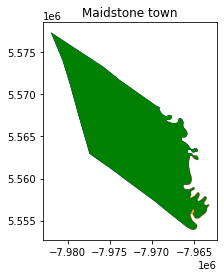

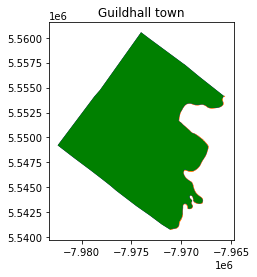

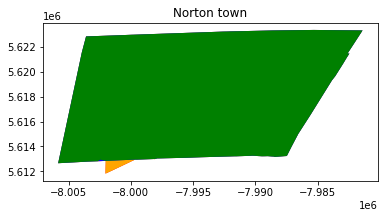

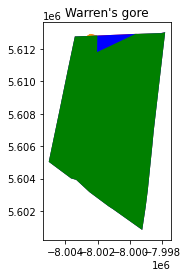

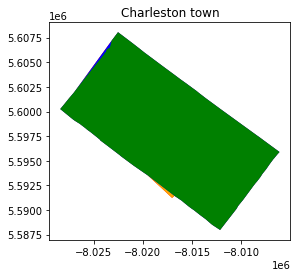

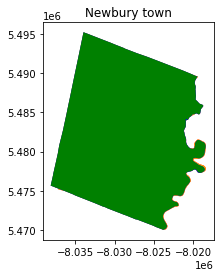

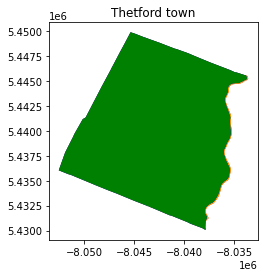

In [50]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,1]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [51]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(284, 1)
0 precincts w/ a difference of 0 km^2
277 precincts w/ a difference between 0 and .1 km^2
7 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


### Look into Warren's Gore & Norton Town Difference

Checking to see if there was a shapefile processing error on our end, and this does not seem to be the case.

<AxesSubplot:>

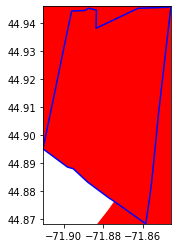

In [52]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Warren's"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Warren's"].exterior.plot(ax=ax,color="blue")

<AxesSubplot:>

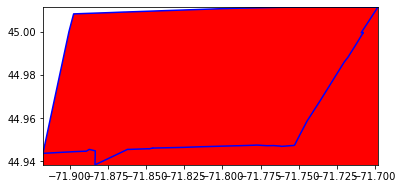

In [53]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Norton"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Norton"].exterior.plot(ax=ax,color="blue")